use pipreqs to freeze only used packages

In [ ]:
!pip install pipreqs
!pipreqs . --force

INFO: Successfully saved requirements file in ./requirements.txt


In [1]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
# move to root directory of repository
%cd /content/drive/MyDrive/ColabNotebooks/clustered-fl

/content/drive/MyDrive/ColabNotebooks/clustered-fl


In [ ]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
from IPython.display import clear_output
import os
from copy import deepcopy

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from models import ConvNet, MLP
from helper import ExperimentLogger, display_train_stats, Checkpoint
from fl_devices import Server, Client
from data_utils import split_noniid, CustomSubset
from custom_datasets import LFWPeopleAttribute
from datasets.gaussian import GaussianDataset

torch.manual_seed(42)
np.random.seed(42)

We will run experiments with the EMNIST data set of handwritten characters. We simulate a scenario with 10 clients and distribute the data among the clients in a non-iid way accoding to a dirichlet distribution parametrized with alpha=1.0 . The distribution of data is shown below.


In [ ]:
# checkpoint = Checkpoint('20220519')
# checkpoint['exp_type'] = 'lfw_attribute'

In [ ]:
N_CLIENTS = 11
DIRICHLET_ALPHA = 1.0

# data = GaussianDataset(20, 10000)

data = LFWPeopleAttribute(
    root = '/content/',
    download = True,
    attribute_classes=[ # todo : delete this and change to default property datasets object
      'Male', # Gender
      'Smiling', # Smile
      'Asian', 'White', 'Black', # Race
      'Baby', 'Child', 'Youth', 'Middle Aged', 'Senior', # Age
      'Black Hair', 'Blond Hair', 'Brown Hair', 'Bald',# Hair
      'No Eyewear', 'Eyeglasses', 'Sunglasses', # Eyewear
    ],
    target_class = 'hair',
    inference_class = 'Black',
  )

# data = datasets.EMNIST(root="/content/", split="byclass", download=True)


# mapp = np.array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C',
#        'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P',
#        'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c',
#        'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p',
#        'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'], dtype='<U1')

idcs = np.random.permutation(len(data))
train_len = int(len(data) * 0.75)
print(f"{train_len} train, {len(data)-train_len} test")
train_idcs, test_idcs = idcs[:train_len], idcs[train_len:]
train_labels = data.targets
print(train_labels.shape)
client_idcs = split_noniid(train_idcs, train_labels, alpha=DIRICHLET_ALPHA, n_clients=N_CLIENTS)

client_data = [CustomSubset(data, idcs) for idcs in client_idcs[:N_CLIENTS]]
test_data = CustomSubset(data, test_idcs, transforms.Compose([transforms.ToTensor()]))

Files already downloaded and verified
Using downloaded and verified file: /content/lfw-py/lfw_attributes.txt
9903 train, 3302 test
(13205,)


In [ ]:
len(client_data)

11

In [ ]:
print(client_idcs[0].shape, client_idcs[1].shape)
print(len(client_idcs), len(client_data))

(989,) (622,)
11 11


In [ ]:
num_class = len(np.unique(train_labels))
num_class

4

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


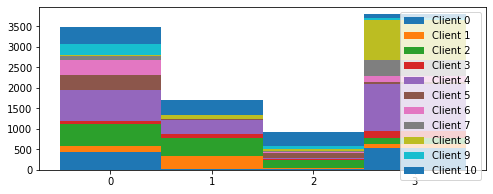

In [ ]:
mapp = np.array(['No Eyewear', 'Eyeglasses', 'Sunglasses'], dtype='<U1')
 
plt.figure(figsize=(8,3))
plt.hist([train_labels[idc]for idc in client_idcs], stacked=True, 
         bins=np.arange(min(train_labels)-0.5, max(train_labels) + 1.5, 1),
        label=["Client {}".format(i) for i in range(N_CLIENTS)])
plt.xticks(np.arange(4)) # , mapp
plt.legend()
plt.show()

Next, we simulate a clustering structure in the client population, by rotating the data for half of the first 5 clients by 180 degree. We display 10 data samples from the 1st and the 6th client for illustration.

In [ ]:
RGB_MEAN = [0.485, 0.456, 0.406]
RGB_STD = [0.229, 0.224, 0.225]
transform = transforms.Compose([
    transforms.Resize((48, 48)),  # make 48 * 48
    transforms.ToTensor(),
    transforms.Normalize(mean = RGB_MEAN, std = RGB_STD),
])


for i, client_datum in enumerate(client_data):
    # if i<5:
    #     client_datum.subset_transform = transforms.Compose([transforms.RandomRotation((180,180)),
    #                                                   transforms.ToTensor()])
    # else:
    client_datum.subset_transform = transform

In [ ]:
clients = [Client(lambda: ConvNet(num_class), lambda x : torch.optim.SGD(x, lr=0.1, momentum=0.9), dat, idnum=i) 
           for i, dat in enumerate(client_data)]
test_client = clients[-1]
clients = clients[:-1]
server = Server(lambda: ConvNet(num_class), test_data)

In [ ]:
len(clients)

10

In [ ]:
client_data[0][0][0].shape

torch.Size([3, 48, 48])

Client 0:


IndexError: ignored

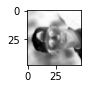

In [ ]:
for client in [clients[0], clients[5]]:
    x, y = iter(client.train_loader).next()

    print("Client {}:".format(client.id))
    plt.figure(figsize=(15,1))
    for i in range(10):
        plt.subplot(1,10,i+1)
        plt.imshow(x[i,0].numpy().T, cmap="Greys")
        plt.title("Label: {}".format(mapp[y[i].item()]))
    plt.show()

Now everything is set up to run our Clustered Federated Learning algorithm. During training, we will track the mean and std client accuracies, as well as the average and maximum client update norms.

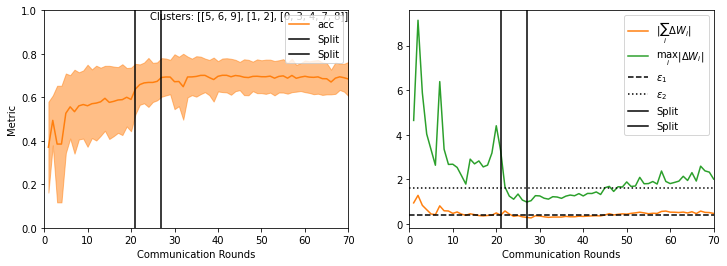

In [ ]:
records = []
COMMUNICATION_ROUNDS = 70
EPS_1 = 0.4
EPS_2 = 1.6

cfl_stats = ExperimentLogger()

cluster_indices = [np.arange(len(clients)).astype("int")]
# set initial clusters with iid datasets
client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]

print(cluster_indices)
# algorithm can be found at Algorithm 5

for c_round in range(1, COMMUNICATION_ROUNDS+1):

    # initialize
    if c_round == 1:
        for client in clients:
            client.synchronize_with_server(server)

    # client does
    # assume) all clients participate each round (frac = 1.0)
    participating_clients = server.select_clients(clients, frac=1.0)

    for client in participating_clients:
        train_stats = client.compute_weight_update(epochs=1)
        client.reset()

    # line 15
    similarities = server.compute_pairwise_similarities(clients)

    # we start with empty list unlike line 11
    cluster_indices_new = []

    # server does
    for idc in cluster_indices:
        # max norm for line 14
        max_norm = server.compute_max_update_norm([clients[i] for i in idc])
        # line 13
        mean_norm = server.compute_mean_update_norm([clients[i] for i in idc])
        # line 14
        if mean_norm<EPS_1 and max_norm>EPS_2 and len(idc)>2 and c_round>20: # we use clustering since round 20
            
            server.cache_model(idc, clients[idc[0]].W, acc_clients)
            # line 16, use pre-calculated similarites
            c1, c2 = server.cluster_clients(similarities[idc][:,idc]) 
            # line 19, line 18 is not implemented, we cant find gamma implemented
            c1 = idc[c1]
            c2 = idc[c2]
            records.append([idc, c1, c2])
            cluster_indices_new += [c1, c2]
            cfl_stats.log({"split" : c_round})

        else:
            cluster_indices_new += [idc]

    # line 23
    cluster_indices = cluster_indices_new
    client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]

    server.aggregate_clusterwise(client_clusters)

    f1_clients = [client.evaluate(mode='f1') for client in clients]
    acc_clients = [client.evaluate(mode='acc') for client in clients]
    cfl_stats.log({"f1_clients" : f1_clients, "acc_clients" : acc_clients, "mean_norm" : mean_norm, "max_norm" : max_norm,
                  "rounds" : c_round, "clusters" : cluster_indices})
    # print(acc_clients)
    display_train_stats(cfl_stats, EPS_1, EPS_2, COMMUNICATION_ROUNDS)
# cluster_indices = 

for idc in cluster_indices:
    server.cache_model(idc, clients[idc[0]].W, acc_clients)
    # 5, 0, 1, 8

In [ ]:
records

[[array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
  array([1, 2, 5, 6, 9]),
  array([0, 3, 4, 7, 8])],
 [array([1, 2, 5, 6, 9]), array([5, 6, 9]), array([1, 2])]]

In [ ]:
def get_model_tree(records, model_cache):
  def find_model(target_idc, model_cache):
    for idc, param, _ in model_cache:
      if np.array_equal(idc, target_idc):
        return param
    return None

  model_tree = [None] * 7 # todo - more efficient memory...

  max_index = -1
  for p, c1, c2 in records:
    p_index = None
    for i, m in enumerate(model_tree):
      if m is None:
        continue
      if np.array_equal(m["index"], p):
        p_index = i
    if p_index is None:
      p_index = 0

    c1_index = p_index * 2 + 1
    c2_index = p_index * 2 + 2

    p_param = find_model(p, model_cache)
    c1_param = find_model(c1, model_cache)
    c2_param = find_model(c2, model_cache)
    model_tree[p_index] = {
      "index": p,
      "param": p_param,
      "childs": [c1, c2]
    }
    model_tree[c1_index] = {
      "index": c1,
      "param": c1_param,
    }
    model_tree[c2_index] = {
      "index": c2,
      "param": c2_param,
    }
  return model_tree

model_tree = get_model_tree(records, server.model_cache)

In [ ]:
for m in model_tree:
  if m is not None:
    print(m["index"], m.get("childs"), m.get("param") == None)
  else:
    print(m)

[0 1 2 3 4 5 6 7 8 9] [array([1, 2, 5, 6, 9]), array([0, 3, 4, 7, 8])] False
[1 2 5 6 9] [array([5, 6, 9]), array([1, 2])] False
[0 3 4 7 8] None False
[5 6 9] None False
[1 2] None False
None
None


In [ ]:
from fl_devices import flatten

def assign_new_model(clients, test_client, model_tree, n):
  current_node_index = 0
  current_node = model_tree[0]
  while current_node.get("childs") is not None:
    for client in clients:
      client.optimizer.param_groups[0]["lr"] = 0.01
    test_client.optimizer.param_groups[0]["lr"] = 0.01

    c1, c2 = current_node.get("childs")
    c1_clients = [clients[idx] for idx in c1]
    c2_clients = [clients[idx] for idx in c2]
    c1_dWs = []
    c2_dWs = []
    for c1_client in c1_clients:
      c1_client.load_weight(current_node.get("param"))
      c1_client.reset()
      c1_client.compute_weight_update(epochs=n)
      c1_dWs.append(flatten(c1_client.dW))
    for c2_client in c2_clients:
      c2_client.load_weight(current_node.get("param"))
      c2_client.reset()
      c2_client.compute_weight_update(epochs=n)
      c2_dWs.append(flatten(c2_client.dW))

    test_client.load_weight(current_node.get("param"))
    test_client.reset() # update self.W to self.W+old
    test_client.compute_weight_update(epochs=n) # todo epochs 1 is enough?
    test_dW = flatten(test_client.dW)

    c1_alphas = [torch.sum(c1_dW * test_dW) / (torch.norm(c1_dW)*torch.norm(test_dW)) for c1_dW in c1_dWs]
    c1_alpha = max(c1_alphas)
    c2_alphas = [torch.sum(c2_dW * test_dW) / (torch.norm(c2_dW)*torch.norm(test_dW)) for c2_dW in c2_dWs]
    c2_alpha = max(c2_alphas)


    if c2_alpha > c1_alpha:
      current_node_index = current_node_index * 2 + 2
    else:
      current_node_index = current_node_index * 2 + 1

    before_node = current_node
    current_node = model_tree[current_node_index]
    print(f'current_node: {before_node.get("index")}, childs: {before_node.get("childs")}')
    print(f'going: {current_node.get("index")}, c1_alpha: {c1_alpha}, c2_alpha: {c2_alpha}')

assign_new_model(clients, test_client, model_tree, n = 20)

current_node: [0 1 2 3 4 5 6 7 8 9], childs: [array([1, 2, 5, 6, 9]), array([0, 3, 4, 7, 8])]
going: [1 2 5 6 9], c1_alpha: 0.014358836226165295, c2_alpha: 0.009552963078022003
current_node: [1 2 5 6 9], childs: [array([5, 6, 9]), array([1, 2])]
going: [5 6 9], c1_alpha: 0.014875826425850391, c2_alpha: -0.01098103541880846


In [ ]:
clients[0].optimizer.param_groups[0]["lr"]

0.046588077516979354

In [ ]:
results = np.zeros([N_CLIENTS, len(server.model_cache)])
for i, (idcs, W, accs) in enumerate(server.model_cache):
    results[idcs, i] = np.array(accs)

frame = pd.DataFrame(results, columns=["FL Model"]+["Model {}".format(i) 
                                                    for i in range(results.shape[1]-1)],
            index = ["Client {}".format(i) for i in range(results.shape[0])])

def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

frame.T.style.apply(highlight_max)

,Client 0,Client 1,Client 2,Client 3,Client 4,Client 5,Client 6,Client 7,Client 8,Client 9,Client 10
FL Model,0.742424,0.360000,0.428016,0.565789,0.725275,0.581818,0.740741,0.692308,0.757576,0.670886,0.000000
Model 0,0.000000,0.560000,0.595331,0.486842,0.000000,0.663636,0.685185,0.000000,0.000000,0.670886,0.000000
Model 1,0.000000,0.656000,0.599222,0.578947,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Model 2,0.000000,0.000000,0.000000,0.000000,0.000000,0.645455,0.750000,0.000000,0.000000,0.734177,0.000000
Model 3,0.732323,0.000000,0.000000,0.000000,0.676923,0.000000,0.000000,0.721154,0.796537,0.000000,0.000000


In [ ]:
model = ConvNet()

In [ ]:
model.load_state_dict(server.model_cache[0][1])

<All keys matched successfully>

In [ ]:
for idcs, W, accs in server.model_cache:


tensor([ 0.0041, -0.0698, -0.1206,  0.1502,  0.0799, -0.1435, -0.0340,  0.0766,
        -0.1495,  0.0391, -0.0319,  0.0619, -0.1775, -0.2211, -0.1420, -0.0207,
         0.1159, -0.0095,  0.0715, -0.0937,  0.1728, -0.0257,  0.1930, -0.0667,
         0.0550, -0.0590,  0.1061,  0.0104,  0.0696, -0.0251, -0.0769, -0.0490],
       device='cuda:0')
tensor([ 0.0091, -0.0424, -0.2181,  0.2454,  0.0693, -0.1847,  0.0207,  0.0845,
        -0.2076,  0.0716, -0.0300,  0.0270, -0.2024, -0.2413, -0.1536, -0.0153,
         0.1520, -0.0424,  0.0512, -0.0533,  0.1640,  0.0074,  0.2478, -0.0723,
         0.0207, -0.0402,  0.1164,  0.0006,  0.1311, -0.0249, -0.0757, -0.0361],
       device='cuda:0')
tensor([-0.0574, -0.0764, -0.2523,  0.1637,  0.0844, -0.2093, -0.0065,  0.0551,
        -0.2548,  0.0049, -0.0540,  0.0475, -0.2418, -0.2828, -0.2521, -0.0206,
         0.0578, -0.0985,  0.0231, -0.0950,  0.1764, -0.0621,  0.2182, -0.0864,
        -0.0049, -0.0530,  0.1427, -0.0664,  0.1877, -0.0796, -0.1309,

In [ ]:
client = 

tensor([-0.0574, -0.0764, -0.2523,  0.1637,  0.0844, -0.2093, -0.0065,  0.0551,
        -0.2548,  0.0049, -0.0540,  0.0475, -0.2418, -0.2828, -0.2521, -0.0206,
         0.0578, -0.0985,  0.0231, -0.0950,  0.1764, -0.0621,  0.2182, -0.0864,
        -0.0049, -0.0530,  0.1427, -0.0664,  0.1877, -0.0796, -0.1309, -0.0228],
       device='cuda:0')

The training process resulted in multiple models for every client: A Federated Learning base model as well as more specialized models for the different clusters.  We can now compare their accuracies on the clients' validation sets, and assign each client the model which performed best.

In [ ]:
results = np.zeros([10, len(server.model_cache)])
for i, (idcs, W, accs) in enumerate(server.model_cache):
    results[idcs, i] = np.array(accs)

frame = pd.DataFrame(results, columns=["FL Model"]+["Model {}".format(i) 
                                                    for i in range(results.shape[1]-1)],
            index = ["Client {}".format(i) for i in range(results.shape[0])])

def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

frame.T.style.apply(highlight_max)

,Client 0,Client 1,Client 2,Client 3,Client 4,Client 5,Client 6,Client 7,Client 8,Client 9
FL Model,0.891525,0.752577,0.896797,0.960000,0.872727,0.937500,0.886598,0.878788,0.915663,0.877698


As we can see, clustering improoved the accuracy for all clients by about 10%.

In [ ]:
cluster_indices

[array([1, 4, 6, 7, 8]), array([0, 2, 3, 5, 9])]

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


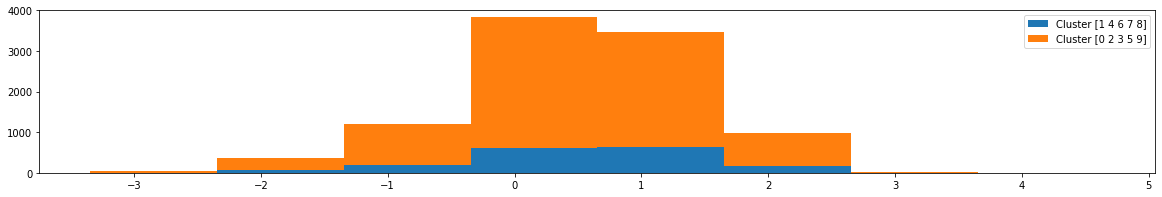

In [ ]:
inference_labels = data.attributes

plt.figure(figsize=(20,3))

all_cluster_inference_labels = []
for cluster_indice in cluster_indices:
  cluster_inference_labels = np.array([])
  for cluster_idx in cluster_indice:
    idc = client_idcs[cluster_idx]
    # print(inference_labels[idc])
    cluster_inference_labels = np.concatenate((inference_labels[idc], cluster_inference_labels))
  all_cluster_inference_labels.append(cluster_inference_labels)

mapp = np.array(['F', 'M'], dtype='<U1')


plt.hist(all_cluster_inference_labels, stacked=True, 
         bins=np.arange(min(inference_labels)-0.5, max(inference_labels) + 1.5, 1),
        label=[f"Cluster {cluster_indice}" for cluster_indice in cluster_indices])
plt.xticks()
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


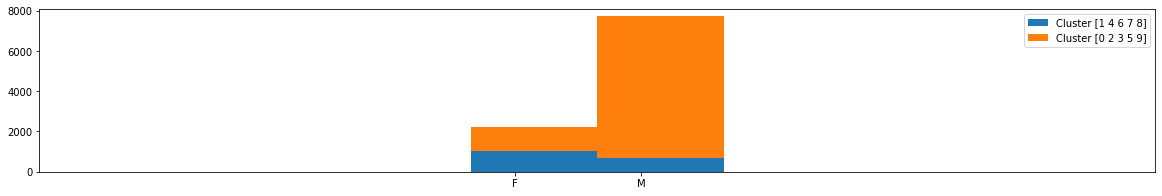

In [ ]:
all_cluster_train_labels = []
for cluster_indice in cluster_indices:
  cluster_train_labels = np.array([])
  for cluster_idx in cluster_indice:
    idc = client_idcs[cluster_idx]
    # print(inference_labels[idc])
    cluster_train_labels = np.concatenate((train_labels[idc], cluster_train_labels))
  all_cluster_train_labels.append(cluster_train_labels)

plt.figure(figsize=(20,3))
plt.hist(all_cluster_train_labels, stacked=True, 
         bins=np.arange(min(inference_labels)-0.5, max(inference_labels) + 1.5, 1),
        label=[f"Cluster {cluster_indice}" for cluster_indice in cluster_indices])

plt.xticks(np.arange(2), mapp)
plt.legend()
plt.show()

In [ ]:
cluster_ratio

[1.4716157205240175, 0.16930312099187686]

No handles with labels found to put in legend.


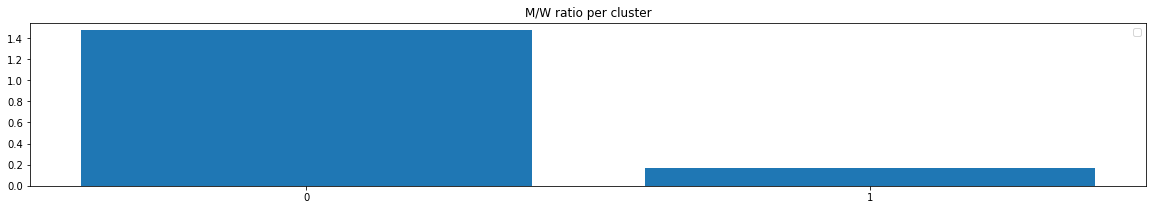

In [ ]:
cluster_ratio = []
for cluster_indice in cluster_indices:
  cluster_train_labels = np.array([])
  for cluster_idx in cluster_indice:
    idc = client_idcs[cluster_idx]
    # print(inference_labels[idc])
    cluster_train_labels = np.concatenate((train_labels[idc], cluster_train_labels))
  num_zeros = (cluster_train_labels == 0).sum()
  num_ones = (cluster_train_labels == 1).sum()

  cluster_ratio.append(num_zeros / num_ones)

plt.figure(figsize=(20,3))
plt.bar(range(len(cluster_indices)), cluster_ratio)
plt.title('M/W ratio per cluster')

plt.xticks(range(len(cluster_indices)))
plt.legend()
plt.show()

No handles with labels found to put in legend.


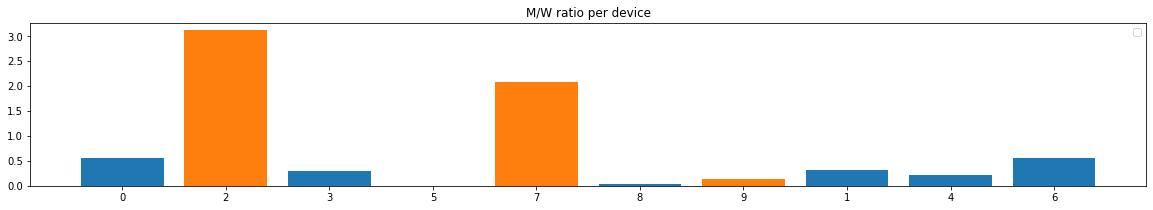

In [ ]:
device_ratio = []
colors = []
device_nums = []

for i, cluster_indice in enumerate(cluster_indices):
  cluster_train_labels = np.array([])
  for cluster_idx in cluster_indice:
    idc = client_idcs[cluster_idx]
    # print(inference_labels[idc])
    num_zeros = (train_labels[idc] == 0).sum()
    num_ones = (train_labels[idc] == 1).sum()
    device_ratio.append(num_zeros / num_ones)
    colors.append(f'C{i}')
    device_nums.append(cluster_idx)

plt.figure(figsize=(20,3))
plt.bar(device_nums, device_ratio, color=colors)
plt.title('M/W ratio per device')

plt.xticks(range(len(device_nums)), device_nums)
plt.legend()
plt.show()

In [ ]:
import numpy as np
import tqdm

X = np.empty((0, 256))
ys = np.array([])
devices = np.array([])
clusters = np.array([])

device = "cuda" if torch.cuda.is_available() else "cpu"

server_model = server.model
server_model.eval()

for i, cluster_indice in enumerate(cluster_indices):
  for client_idx in cluster_indice:
    for input, label in tqdm.tqdm(client_data[client_idx]):
      input = input.to(device)
      output = server_model.get_feature(input)
      output = output.cpu().detach().numpy()
      X = np.append(X, output, axis = 0)
      ys = np.append(ys, label)
      devices = np.append(devices, client_idx)
      clusters = np.append(clusters, i)
print(X.shape)
print(ys.shape)
print(devices.shape)
print(clusters.shape)


100%|██████████| 718/718 [00:05<00:00, 142.58it/s]

(9903, 256)
(9903,)
(9903,)
(9903,)


In [ ]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random').fit_transform(X)

In [ ]:
from umap import UMAP
X_embedded_umap = UMAP(n_components=2, init='random', random_state=0).fit_transform(X)


In [ ]:
clusters = clusters.astype(str)
devices = devices.astype(str)
ys = ys.astype(str)


In [ ]:
import plotly.express as px

fig = px.scatter(
    X_embedded_umap,
    x=0,
    y=1,
    color=ys,
    labels={
        'color': 'ys',
    }
    #     'devices': devices,
    #     'cluster': clusters
    #   }
)
fig.show()

In [ ]:
#done
"""
accuracy / f1 score
F/M ratio per device in one cluster
F/M ratio per cluster
evaluation none cluster FL setting vs cluster FL setting
"""
#todo
"""
- cluster 별로 TSNE/UMAP 찍어서 달라지는지 보기 (perturbation 가능성)
"""

# todo - next sprint

"""
perturbation for changing cluster
"""


In [ ]:
import numpy as np
import tqdm
from fl_devices import flatten

Ws = np.empty((0, 618306))
devices = np.array([])
clusters = np.array([])


for i, cluster_indice in enumerate(cluster_indices):
  for client_idx in cluster_indice:
    c = clients[client_idx]
    W = flatten(c.W)
    W = W.unsqueeze(0).cpu().detach().numpy()
    Ws = np.append(Ws, W, axis = 0)
    devices = np.append(devices, client_idx)
    clusters = np.append(clusters, i)
print(Ws.shape)
print(devices.shape)
print(clusters.shape)
clusters = clusters.astype(str)
devices = devices.astype(str)


(10, 618306)
(10,)
(10,)


In [ ]:
from umap import UMAP
W_embedded_umap = UMAP(n_components=2, init='random', random_state=0).fit_transform(Ws)
W_embedded_umap.shape

/usr/local/lib/python3.7/dist-packages/umap/umap_.py:2345: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



(10, 2)

In [ ]:
similarities

array([[ 0.99999994,  0.20795031,  0.38516614, -0.85059816, -0.3796459 ,
        -0.41239244,  0.34898078,  0.40266895, -0.17172343,  0.7015314 ],
       [ 0.20795031,  0.9999999 ,  0.11064746, -0.19260596, -0.49175572,
        -0.08571052,  0.3833564 ,  0.31932992, -0.08956137,  0.1793483 ],
       [ 0.38516614,  0.11064746,  1.0000001 , -0.4061813 , -0.17355198,
        -0.35459462,  0.18414488,  0.19205607,  0.03607554,  0.28590682],
       [-0.85059816, -0.19260596, -0.4061813 ,  1.        ,  0.43885732,
         0.36783034, -0.3850074 , -0.3980321 ,  0.22161716, -0.77197534],
       [-0.3796459 , -0.49175572, -0.17355198,  0.43885732,  1.        ,
         0.2515414 , -0.73886895, -0.6429996 ,  0.16709761, -0.3666511 ],
       [-0.41239244, -0.08571052, -0.35459462,  0.36783034,  0.2515414 ,
         1.        , -0.14919043, -0.22939464,  0.09707236, -0.4184374 ],
       [ 0.34898078,  0.3833564 ,  0.18414488, -0.3850074 , -0.73886895,
        -0.14919043,  1.0000001 ,  0.47265872

In [ ]:
cluster_indices

[array([1, 4, 6, 7, 8]), array([0, 2, 3, 5, 9])]

In [ ]:
import plotly.figure_factory as ff

z = similarities

x = np.zeros(10)
x = x.astype(str)

for i, cluster_indice in enumerate(cluster_indices):
  for j in cluster_indice:
    x[j] = f'd:{j} c:{i}'
y = list(x)
x = list(x)

# change each element of z to type string for annotations
z_text = [[f'{y:2f}' for y in x] for x in z]

# set up figure 
fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='Viridis')

# add title
fig.update_layout(title_text='<i><b>Confusion matrix</b></i>',
                  #xaxis = dict(title='x'),
                  #yaxis = dict(title='x')
                 )

# add custom xaxis title
fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=0.5,
                        y=-0.15,
                        showarrow=False,
                        text="Predicted value",
                        xref="paper",
                        yref="paper"))

# add custom yaxis title
fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=-0.35,
                        y=0.5,
                        showarrow=False,
                        text="Real value",
                        textangle=-90,
                        xref="paper",
                        yref="paper"))

# adjust margins to make room for yaxis title
fig.update_layout(margin=dict(t=50, l=200))

# add colorbar
fig['data'][0]['showscale'] = True
fig.show()


In [ ]:
fig = px.scatter(
    W_embedded_umap,
    x=0,
    y=1,
    color=clusters,
    labels={
        'color': 'clusters',
    }
    #     'devices': devices,
    #     'cluster': clusters
    #   }
)
fig.show()

In [ ]:
# todo
"""
다른 방식으로 distribution의 차이 보기 (TSNE 말고)
 - 
synthetic dataset (gaussian 2개) 분포 만들어서 한번 잘 맞추는지 보기
 - 
"""